In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [14]:
# ------------------------------
# 1. Parameter Setup (Calibrated)
# ------------------------------
a = 0.13       # Example mean-reversion speed
b = 3.06/100       # Example long-run mean
sigma = 0.98/100   # Example volatility
r0 = 0.987200022/100     # Example initial short rate

DataSet downloading

In [15]:
df = pd.read_excel('data/case_study_data.xlsx', sheet_name=1)

In [16]:
df.columns = df.iloc[0]
df.columns
index = df['Maturity (years)'][2:]
index.name = 'Date'
df = df[2:]
df.index = index
df

,Maturity (years),0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-31,2014-10-31 00:00:00,0.001525,0.001525,0.005385,0.009872,0.013707,0.016728,0.019069,0.020903,0.022370,...,0.030328,0.030618,0.030887,0.031137,0.031370,0.031587,0.031791,0.031981,0.032160,0.032327
2014-11-03,2014-11-03 00:00:00,0.001631,0.001631,0.005533,0.010066,0.013901,0.016893,0.019199,0.020998,0.022437,...,0.030274,0.030560,0.030825,0.031071,0.031299,0.031513,0.031712,0.031899,0.032074,0.032238
2014-11-04,2014-11-04 00:00:00,0.001439,0.001439,0.005512,0.010062,0.013873,0.016836,0.019115,0.020892,0.022312,...,0.030027,0.030307,0.030566,0.030807,0.031032,0.031241,0.031436,0.031619,0.031790,0.031951
2014-11-05,2014-11-05 00:00:00,0.001556,0.001556,0.005611,0.010135,0.013922,0.016873,0.019152,0.020938,0.022374,...,0.030160,0.030433,0.030685,0.030918,0.031135,0.031335,0.031523,0.031697,0.031860,0.032013
2014-11-06,2014-11-06 00:00:00,0.001682,0.001682,0.005814,0.010413,0.014241,0.017211,0.019498,0.021290,0.022729,...,0.030549,0.030822,0.031074,0.031307,0.031523,0.031723,0.031910,0.032084,0.032246,0.032398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-28,2024-10-28 00:00:00,0.042701,0.042701,0.040979,0.040501,0.040558,0.040855,0.041258,0.041703,0.042157,...,0.046125,0.046271,0.046398,0.046509,0.046604,0.046683,0.046749,0.046801,0.046841,0.046870
2024-10-29,2024-10-29 00:00:00,0.042583,0.042583,0.040861,0.040406,0.040491,0.040813,0.041238,0.041702,0.042171,...,0.046145,0.046283,0.046402,0.046503,0.046588,0.046658,0.046713,0.046755,0.046785,0.046803
2024-10-30,2024-10-30 00:00:00,0.042760,0.042760,0.041321,0.040869,0.040888,0.041134,0.041487,0.041885,0.042296,...,0.045830,0.045949,0.046051,0.046138,0.046209,0.046267,0.046311,0.046343,0.046364,0.046374


Set up time ranges

In [17]:
# ------------------------------
# 2. Date Ranges
# ------------------------------


dates = df.index
N = len(dates)

# day_count convention (simple 1/365)
dt = 1.0/365.0

Vasicek simulation of short-term risk-free rates

In [18]:
# ------------------------------
# 3. Simulate Short-Rate Path
# ------------------------------
r = np.zeros(N)
r[0] = r0

# Euler-Maruyama discretization for Vasicek:
# dr_t = a(b - r_t)*dt + sigma * sqrt(dt)*Z,  Z ~ N(0,1)
for i in range(1, N):
    z = np.random.randn()
    dr = a*(b - r[i-1])*dt + sigma*np.sqrt(dt)*z
    r[i] = r[i-1] + dr

Find price of zero-coupon bond

In [19]:

# ------------------------------
# 4. Function for Vasicek ZCB Price
# ------------------------------
def vasicek_zcb_price(r_t, tau, a, b, sigma):
    """
    Returns price P(t, t+tau) of a zero-coupon bond
    under the Vasicek model, given:
      r_t : short rate at time t
      tau : time to maturity in years
      a,b,sigma : Vasicek parameters
    """
    # B(t,T) = (1 - e^{-a(T - t)}) / a
    B = (1.0 - np.exp(-a*tau)) / a
    
    # A(t,T) = b[B - tau] - (sigma^2/(4a)) * B^2
    #        + possible - (sigma^2/(2a^2)) * ...
    # The more standard closed-form is:
    #   A = ( b - sigma^2/(2a^2) ) * (B - tau) 
    #       - (sigma^2/(4a)) * B^2
    # but we can directly plug in the known formula:
    
    term1 = (b - (sigma**2)/(2.0*a**2))*(B - tau)
    term2 = (sigma**2)/(4.0*a) * B**2
    A = term1 - term2
    
    return np.exp(-A - B*r_t)

Example: 3-year zero-coupon bond

In [20]:
# ------------------------------
# 5. Compute the 3-Year Bond Index
# ------------------------------
maturity = 3.0  # constant 3-year maturity
bond_prices = np.zeros(N)

for i in range(N):
    bond_prices[i] = vasicek_zcb_price(r[i], 
                                       maturity, 
                                       a, b, sigma)


In [21]:
df_bond['bond_return'] = df_bond['ZCB_3yr'].pct_change()

In [22]:
df_bond

,Short_Rate,ZCB_3yr,bond_return
Date,,,
2014-10-31,0.009872,0.990975,NaN
2014-11-03,0.008836,0.993530,0.002578
2014-11-04,0.009604,0.991635,-0.001908
2014-11-05,0.009822,0.991098,-0.000542
2014-11-06,0.010194,0.990184,-0.000922
...,...,...,...
2024-10-28,0.010899,0.988451,-0.000055
2024-10-29,0.010594,0.989200,0.000759
2024-10-30,0.010819,0.988646,-0.000560


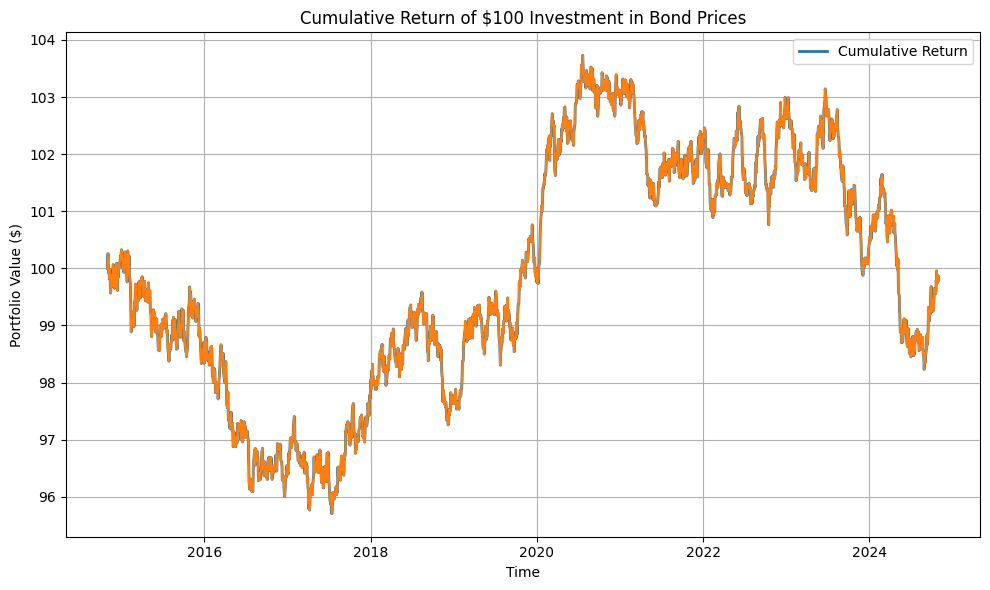

In [38]:
# Calculate cumulative return starting with $100
initial_investment = 100
cumulative_return = initial_investment * (1 + df_bond['bond_return'].fillna(0)).cumprod()

# Plotting the cumulative return
plt.figure(figsize=(10, 6))
plt.plot(cumulative_return, label='Cumulative Return', linewidth=2)
plt.plot(df_bond['ZCB_3yr']*100/0.990975)
plt.title('Cumulative Return of $100 Investment in Bond Prices')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
# Precompute B(T-t)
def B(t, T, a):
    return (1 - np.exp(-a * (T - t))) / a

In [24]:
# Function to calculate A(t, T) using the provided B(t, T)
def A_vasicek_with_B(t, T, a, b, sigma):
    """
    Calculate the A(t, T) component using the given B(t, T) function in the Vasicek bond pricing formula.

    Parameters:
    - t: Current time
    - T: Maturity time of the bond
    - a: Speed of mean reversion
    - b: Long-term mean interest rate
    - sigma: Volatility of the short rate

    Returns:
    - A(t, T)
    """
    B_value = B(t, T, a)
    
    # Formula for A(t, T)
    A = (b - (sigma ** 2) / (2 * a ** 2)) * (B_value - (T - t)) - (sigma ** 2) * B_value ** 2 / (4 * a)
    
    return A

In [39]:
def simulate_and_store_paths(M, N, a, b, sigma, r0, T, dt):
    """
    Simulate and store short rate and bond return paths under the Vasicek model.

    Parameters:
        M (int): Number of simulation paths.
        N (int): Number of time steps.
        a (float): Speed of mean reversion.
        b (float): Long-term mean interest rate.
        sigma (float): Volatility of interest rate.
        r0 (float): Initial short rate.
        T (float): Bond maturity in years.
        dt (float): Time step size.

    Returns:
        r_paths (ndarray): Simulated short rate paths (M x N).
        bond_return_paths (ndarray): Simulated bond return paths (M x N).
    """

    r_paths = np.zeros((M, N))
    bond_return_paths = np.zeros((M, N))
    
    for i in range(M):
        r = np.zeros(N)
        bond_return = np.zeros(N)
        r[0] = r0
        bond_return[0] = 1  # Start with a normalized value of 1
        dW = np.random.normal(0, np.sqrt(dt), N-1)  # Shared Brownian motion

        # Simulate short rate and bond return paths
        for j in range(1, N):
            dr = a * (b - r[j-1]) * dt + sigma * dW[j-1]
            r[j] = r[j-1] + dr
            BtT = B(j * dt, T+j*dt, a) # tT = 3
            bond_return[j] = bond_return[j-1] * np.exp(r[j-1] * dt - BtT * sigma * dW[j-1])

        r_paths[i, :] = r
        bond_return_paths[i, :] = bond_return

    return r_paths, bond_return_paths

In [40]:
# Function to calculate the bond price under the Vasicek model
def vasicek_bond_price(t, T, r_t, a, b, sigma):
    B = (1 - np.exp(-a * (T - t))) / a
    A = (b - (sigma ** 2) / (2 * a ** 2)) * (B - (T - t)) - (sigma ** 2) * B ** 2 / (4 * a)
    return np.exp(A - B * r_t)

# Updated function to simulate short rate, bond return, and cumulative return
def simulate_and_store_paths(M, N, a, b, sigma, r0, T, dt):
    """
    Simulate short rate paths, bond returns, and cumulative returns under the Vasicek model.

    Parameters:
        M (int): Number of simulation paths.
        N (int): Number of time steps.
        a (float): Speed of mean reversion.
        b (float): Long-term mean interest rate.
        sigma (float): Volatility of interest rate.
        r0 (float): Initial short rate.
        T (float): Bond maturity in years.
        dt (float): Time step size.

    Returns:
        r_paths (ndarray): Simulated short rate paths (M x N).
        bond_return_paths (ndarray): Bond returns at each step (M x N).
        cumulative_return_paths (ndarray): Cumulative returns (M x N) starting from 1.
    """
    r_paths = np.zeros((M, N))
    bond_prices_paths = np.zeros((M,N))
    bond_return_paths = np.zeros((M, N))
    cumulative_return_paths = np.ones((M, N))  # Start with 1 for initial investment

    for i in range(M):
        r = np.zeros(N)
        bond_prices = np.zeros(N)
        bond_return = np.zeros(N)
        cumulative_return = np.ones(N)
        r[0] = r0
        bond_prices[0] = vasicek_bond_price(0, T, r0, a, b, sigma)

        # Simulate short rate and calculate bond returns
        for j in range(1, N):
            dW = np.random.normal(0, np.sqrt(dt))  # Shared Brownian motion
            dr = a * (b - r[j - 1]) * dt + sigma * dW
            r[j] = r[j - 1] + dr

            # Calculate bond prices at time t 
            bond_prices[j] = vasicek_bond_price(j * dt, T + j * dt, r[j], a, b, sigma)

            # Calculate bond return based on price ratio
            bond_return[j] = (bond_prices[j] / bond_prices[j-1]) - 1

            # Calculate cumulative return
            cumulative_return[j] = cumulative_return[j - 1] * (1 + bond_return[j])

        # Store paths
        r_paths[i, :] = r
        bond_prices_paths[i,:] = bond_prices
        bond_return_paths[i, :] = bond_return
        cumulative_return_paths[i, :] = cumulative_return

    return r_paths, bond_prices_paths, bond_return_paths, cumulative_return_paths

In [41]:
# Simulate and store both the bond return path and the short rate path
# ------------------------------
# 1. Parameter Setup (Calibrated)
# ------------------------------
a = 0.13       # Example mean-reversion speed
b = 3.06/100       # Example long-run mean
sigma = 0.98/100   # Example volatility
r0 = 0.987200022/100     # Example initial short rate
dates = df.index
N = len(dates)
# day_count convention (simple 1/365)
dt = 1.0/365.0
T=3


M=10

# Generate and store the paths
r_paths, bond_prices_paths, bond_return_paths,cumulative_return_paths = simulate_and_store_paths(M=M, N=N, a=a, b=b, sigma=sigma, r0=r0, T=T, dt=dt)





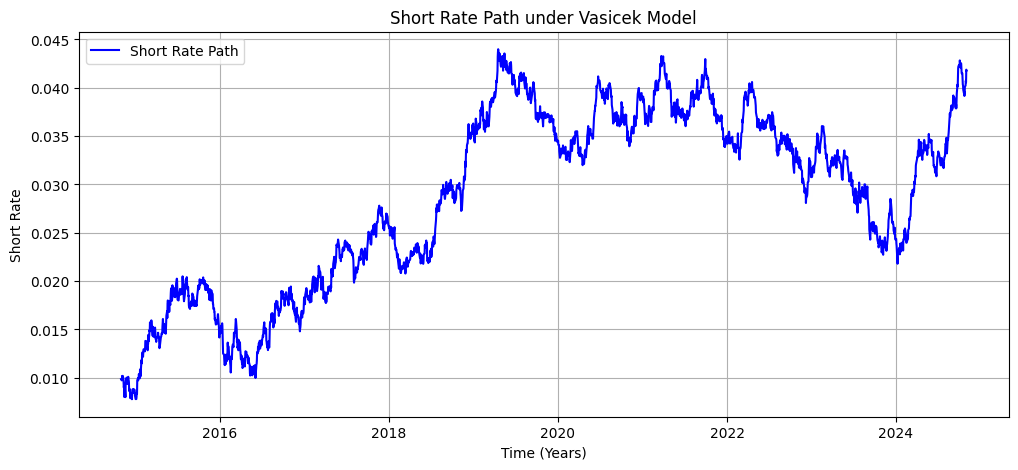

In [42]:
plt.figure(figsize=(12, 5))

# Plot the short rate path
plt.plot(dates, r_paths[0], label='Short Rate Path', color='blue')
plt.title("Short Rate Path under Vasicek Model")
plt.xlabel("Time (Years)")
plt.ylabel("Short Rate")
plt.grid(True)
plt.legend()
plt.show()

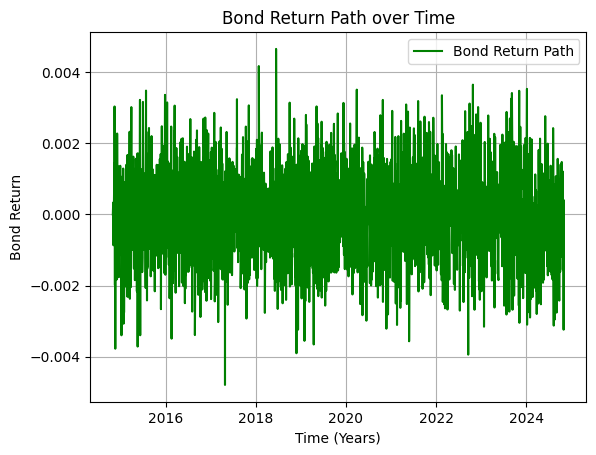

In [43]:
# Plot the bond return path
plt.plot(dates, bond_return_paths[0], label='Bond Return Path', color='green')
plt.title("Bond Return Path over Time")
plt.xlabel("Time (Years)")
plt.ylabel("Bond Return")
plt.grid(True)
plt.legend()
plt.show()


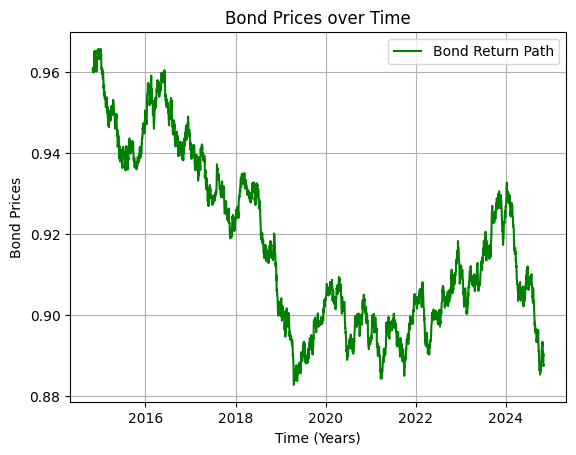

In [44]:
# Plot the bond return path
plt.plot(dates, bond_prices_paths[0], label='Bond Return Path', color='green')
plt.title("Bond Prices over Time")
plt.xlabel("Time (Years)")
plt.ylabel("Bond Prices")
plt.grid(True)
plt.legend()
plt.show()

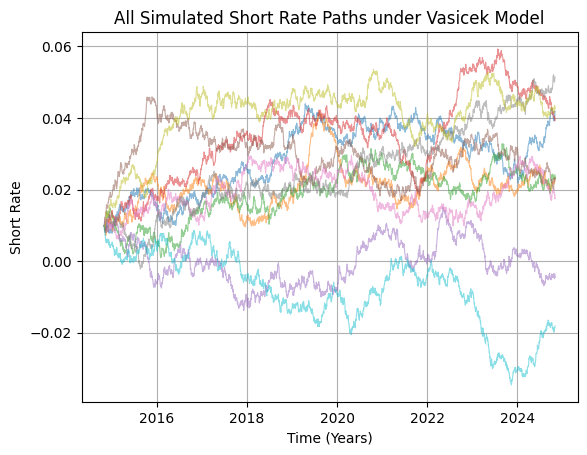

In [45]:
for i in range(M):
    plt.plot(dates, r_paths[i], alpha=0.5,linewidth = 0.8)
plt.title("All Simulated Short Rate Paths under Vasicek Model")
plt.xlabel("Time (Years)")
plt.ylabel("Short Rate")
plt.grid(True)

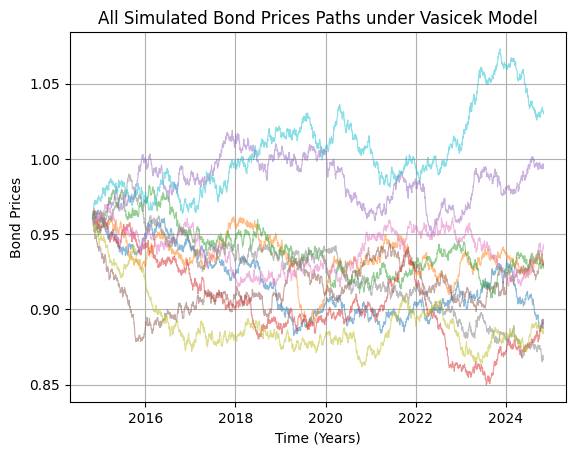

In [46]:
for i in range(M):
    plt.plot(dates, bond_prices_paths[i], alpha=0.5,linewidth = 0.8)
plt.title("All Simulated Bond Prices Paths under Vasicek Model")
plt.xlabel("Time (Years)")
plt.ylabel("Bond Prices")
plt.grid(True)

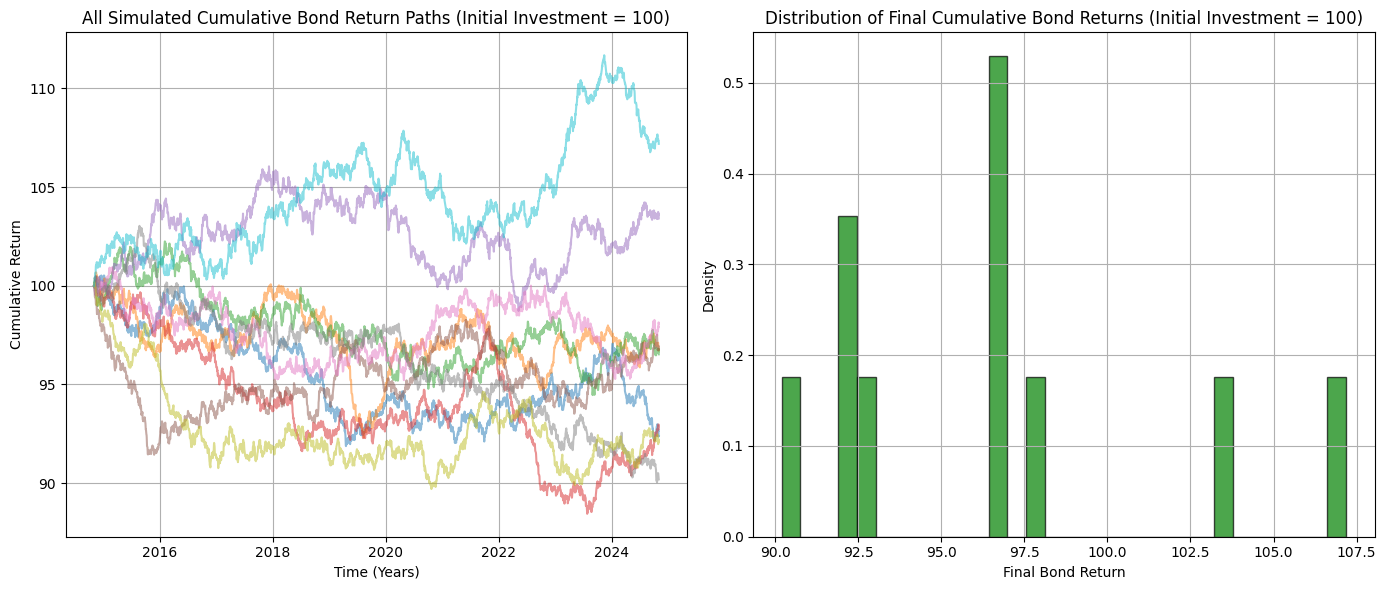

In [49]:
import matplotlib.pyplot as plt
initial_investment = 100
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot all cumulative bond return paths with initial investment = 100
for i in range(M):
    axes[0].plot(dates, cumulative_return_paths[i]*initial_investment, alpha=0.5)

axes[0].set_title("All Simulated Cumulative Bond Return Paths (Initial Investment = 100)")
axes[0].set_xlabel("Time (Years)")
axes[0].set_ylabel("Cumulative Return")
axes[0].grid(True)

# Plot the distribution of final cumulative bond returns
final_returns = cumulative_return_paths[:, -1] * initial_investment  # Final cumulative returns
axes[1].hist(final_returns, bins=30, density=True, color='green', alpha=0.7, edgecolor='black')

axes[1].set_title("Distribution of Final Cumulative Bond Returns (Initial Investment = 100)")
axes[1].set_xlabel("Final Bond Return")
axes[1].set_ylabel("Density")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [29]:
sum(final_returns<100)

4

In [30]:

# Generate descriptive statistics
summary_statistics = {
    'Mean': np.mean(final_returns),
    'Median': np.median(final_returns),
    'Standard Deviation': np.std(final_returns),
    'Minimum': np.min(final_returns),
    'Maximum': np.max(final_returns),
    '25th Percentile (Q1)': np.percentile(final_returns, 25),
    '75th Percentile (Q3)': np.percentile(final_returns, 75),
    'Skewness': pd.Series(final_returns).skew(),
    'Kurtosis': pd.Series(final_returns).kurtosis()
}

# Convert to DataFrame for better presentation
summary_df = pd.DataFrame(summary_statistics, index=["Final Cumulative Return Statistics"]).T

print(summary_df)

                      Final Cumulative Return Statistics
Mean                                           99.864848
Median                                        101.029058
Standard Deviation                              3.910203
Minimum                                        92.537486
Maximum                                       106.927118
25th Percentile (Q1)                           96.916697
75th Percentile (Q3)                          102.044145
Skewness                                       -0.161363
Kurtosis                                        0.023633


In [31]:
bond_return_paths

array([[ 0.00000000e+00,  1.57278028e-03, -2.31800107e-03, ...,
         3.44681043e-07,  2.50836460e-03, -1.14293347e-03],
       [ 0.00000000e+00,  2.68471168e-03,  1.01911898e-03, ...,
         6.97030959e-04,  1.19290928e-04,  2.82992123e-03],
       [ 0.00000000e+00, -6.74242754e-04, -1.27875879e-03, ...,
         1.31187598e-03, -1.17996918e-03, -3.30566595e-04],
       ...,
       [ 0.00000000e+00, -9.86913420e-04,  1.75035731e-03, ...,
         1.27760342e-03, -4.62607352e-04,  2.28854744e-03],
       [ 0.00000000e+00,  1.19795892e-03, -2.67079125e-04, ...,
        -1.12801787e-03,  1.52258195e-04,  2.25248577e-05],
       [ 0.00000000e+00, -2.43119176e-04, -3.11314699e-04, ...,
         1.79881930e-03,  9.18190899e-05, -8.80673551e-04]])

In [32]:
# Convert the array to a DataFrame and assign the existing date index
returns_df = pd.DataFrame(bond_return_paths.T, index=dates)

# Optional: Rename columns for clarity
returns_df.columns = [f'Path_{i+1}' for i in range(bond_return_paths.shape[0])]

# Display the first few rows
returns_df


,Path_1,Path_2,Path_3,Path_4,Path_5,Path_6,Path_7,Path_8,Path_9,Path_10
Date,,,,,,,,,,
2014-10-31,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-11-03,1.572780e-03,0.002685,-0.000674,0.002729,-0.001320,-0.001485,-0.000270,-0.000987,0.001198,-0.000243
2014-11-04,-2.318001e-03,0.001019,-0.001279,0.002321,-0.001758,0.001146,-0.000905,0.001750,-0.000267,-0.000311
2014-11-05,-1.141636e-03,-0.000259,0.001901,0.002549,0.000151,0.000052,-0.001130,-0.000426,0.000158,0.000002
2014-11-06,-3.218497e-03,0.001871,-0.000760,-0.002842,0.000864,0.000946,0.000467,0.001452,-0.001682,0.001816
...,...,...,...,...,...,...,...,...,...,...
2024-10-28,1.475338e-03,-0.001143,-0.000713,-0.000910,0.001399,0.001708,-0.003633,0.001567,0.000636,-0.000834
2024-10-29,1.278260e-03,0.001105,-0.001163,0.000545,0.001814,0.000143,-0.000700,0.001083,-0.000470,-0.003158
2024-10-30,3.446810e-07,0.000697,0.001312,0.002615,-0.002426,-0.003090,0.000402,0.001278,-0.001128,0.001799


In [33]:
# Function to calculate the Present Value (PV) of an annuity with separate discount rates
def annuity_present_value_separate_rates(discount_rates, payment_series):
    """
    Calculate the Present Value (PV) of an annuity with distinct discount rates.

    Parameters:
    - discount_rates: Daily discount rate series (Pandas Series with DateTimeIndex).
    - payment_series: Monthly payment series (Pandas Series with DateTimeIndex, payment = 1 at month-end).

    Returns:
    - PV: Present Value of the annuity.
    """
    # Align the discount rates with payment dates
    aligned_discount_rates = discount_rates.loc[payment_series.index]
    
    # Compute the cumulative discount factor
    discount_factors = (1 + aligned_discount_rates).cumprod()
    
    # Present Value calculation
    PV = (payment_series / discount_factors).sum()
    
    return PV

In [34]:
def annuity_future_value_separate_rates(return_rates, payment_series):
    """
    Calculate the Future Value (FV) of an annuity with distinct return rates.

    Parameters:
    - return_rates: Daily return rate series (Pandas Series with DateTimeIndex).
    - payment_series: Monthly payment series (Pandas Series with DateTimeIndex, payment = 1 at month-end).

    Returns:
    - FV: Future Value of the annuity.
    """
    
    
    # Compute compounding factors for each payment
    aligned_return_rates = (1 + return_rates[::-1]).cumprod()[::-1]
    print(aligned_return_rates)
    # Align the return rates with payment dates
    compounding_factors = aligned_return_rates.loc[payment_series.index]
    
    # Future Value calculation
    FV = (payment_series * compounding_factors).sum()
    
    return FV


In [35]:

aligned_return_rates = returns_df.loc[cash_flow_df.index]
aligned_return_rates

NameError: name 'cash_flow_df' is not defined

In [38]:
df = pd.DataFrame(index=dates)
df

""
Date
2014-10-31
2014-11-03
2014-11-04
2014-11-05
2014-11-06
...
2024-10-28
2024-10-29
2024-10-30


In [39]:
month_end_dates

NameError: name 'month_end_dates' is not defined

In [40]:


# Convert to a DataFrame for illustration
df = pd.DataFrame(index=dates)
df['Dummy'] = 0  # Placeholder column

# 1. Extract the month-end dates
# Correct method to extract actual month-end dates from the return series
month_end_dates = returns_df.groupby(pd.Grouper(freq='M')).apply(lambda x: x.index.max())


# 2. Create a cash flow series with $1 payments at month-end
cash_flow_series = pd.Series(1, index=month_end_dates)

# 3. Convert to a DataFrame for clarity
cash_flow_df = pd.DataFrame({'Cash Flow': cash_flow_series})

cash_flow_df


,Cash Flow
2014-10-31,1
2014-11-28,1
2014-12-31,1
2015-01-30,1
2015-02-27,1
...,...
2024-07-31,1
2024-08-30,1
2024-09-30,1
2024-10-31,1


In [41]:
returns_df

,Path_1,Path_2,Path_3,Path_4,Path_5,Path_6,Path_7,Path_8,Path_9,Path_10
Date,,,,,,,,,,
2014-10-31,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-11-03,1.572780e-03,0.002685,-0.000674,0.002729,-0.001320,-0.001485,-0.000270,-0.000987,0.001198,-0.000243
2014-11-04,-2.318001e-03,0.001019,-0.001279,0.002321,-0.001758,0.001146,-0.000905,0.001750,-0.000267,-0.000311
2014-11-05,-1.141636e-03,-0.000259,0.001901,0.002549,0.000151,0.000052,-0.001130,-0.000426,0.000158,0.000002
2014-11-06,-3.218497e-03,0.001871,-0.000760,-0.002842,0.000864,0.000946,0.000467,0.001452,-0.001682,0.001816
...,...,...,...,...,...,...,...,...,...,...
2024-10-28,1.475338e-03,-0.001143,-0.000713,-0.000910,0.001399,0.001708,-0.003633,0.001567,0.000636,-0.000834
2024-10-29,1.278260e-03,0.001105,-0.001163,0.000545,0.001814,0.000143,-0.000700,0.001083,-0.000470,-0.003158
2024-10-30,3.446810e-07,0.000697,0.001312,0.002615,-0.002426,-0.003090,0.000402,0.001278,-0.001128,0.001799


In [42]:
missing_in_returns = cash_flow_df.index.difference(returns_df.index)
missing_in_payments = cash_flow_df.index.difference(returns_df.index)

print("Dates in payment series but not in returns:\n", missing_in_returns)
print("Dates in returns but not in payment series:\n", missing_in_payments)


Dates in payment series but not in returns:
 DatetimeIndex([], dtype='datetime64[ns]', freq=None)
Dates in returns but not in payment series:
 DatetimeIndex([], dtype='datetime64[ns]', freq=None)


In [43]:
cash_flow_df

,Cash Flow
2014-10-31,1
2014-11-28,1
2014-12-31,1
2015-01-30,1
2015-02-27,1
...,...
2024-07-31,1
2024-08-30,1
2024-09-30,1
2024-10-31,1


In [44]:
fv_result = annuity_future_value_separate_rates(return_rates = returns_df["Path_1"], payment_series = cash_flow_df)
fv_result

Date
2014-10-31    0.925375
2014-11-03    0.925375
2014-11-04    0.923922
2014-11-05    0.926068
2014-11-06    0.927127
                ...   
2024-10-28    1.004122
2024-10-29    1.002643
2024-10-30    1.001363
2024-10-31    1.001363
2024-11-01    0.998857
Name: Path_1, Length: 2518, dtype: float64


2014-10-31 00:00:00    0.0
2014-11-28 00:00:00    0.0
2014-12-31 00:00:00    0.0
2015-01-30 00:00:00    0.0
2015-02-27 00:00:00    0.0
                      ... 
2024-08-30 00:00:00    0.0
2024-09-30 00:00:00    0.0
2024-10-31 00:00:00    0.0
2024-11-01 00:00:00    0.0
Cash Flow              0.0
Length: 123, dtype: float64

In [45]:

# Calculate PV and FV using the defined functions
pv_result = annuity_present_value_separate_rates(discount_rates = returns_df , payment_series = cash_flow_df)
fv_result = annuity_future_value_separate_rates(return_rates = returns_df, payment_series = cash_flow_df)

pv_result, fv_result


              Path_1    Path_2    Path_3    Path_4    Path_5    Path_6  \
Date                                                                     
2014-10-31  0.925375  1.069271  1.027296  1.016130  0.968610  1.020795   
2014-11-03  0.925375  1.069271  1.027296  1.016130  0.968610  1.020795   
2014-11-04  0.923922  1.066408  1.027989  1.013364  0.969891  1.022313   
2014-11-05  0.926068  1.065322  1.029305  1.011018  0.971599  1.021143   
2014-11-06  0.927127  1.065598  1.027352  1.008447  0.971452  1.021089   
...              ...       ...       ...       ...       ...       ...   
2024-10-28  1.004122  1.003609  0.997925  1.003366  1.001152  1.001026   
2024-10-29  1.002643  1.004758  0.998637  1.004280  0.999753  0.999319   
2024-10-30  1.001363  1.003649  0.999800  1.003733  0.997942  0.999176   
2024-10-31  1.001363  1.002950  0.998490  1.001115  1.000369  1.002273   
2024-11-01  0.998857  1.002830  0.999669  1.000196  0.999555  1.000696   

              Path_7    Path_8    Pat

(Cash Flow    0.0
 Path_1       0.0
 Path_10      0.0
 Path_2       0.0
 Path_3       0.0
 Path_4       0.0
 Path_5       0.0
 Path_6       0.0
 Path_7       0.0
 Path_8       0.0
 Path_9       0.0
 dtype: float64,
 Cash Flow    0.0
 Path_1       0.0
 Path_10      0.0
 Path_2       0.0
 Path_3       0.0
 Path_4       0.0
 Path_5       0.0
 Path_6       0.0
 Path_7       0.0
 Path_8       0.0
 Path_9       0.0
 dtype: float64)